In [1]:
import sys
sys.path.append('/opt/conda/pkgs')
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/4262b1bf4bf1ffb403c0eb7a42ad5906_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/4506eccf78279d93d0e8a34c035e91c5_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/6bda807e3967eae797c7b1b9eeaee8db_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/c2a47d89d1d34e789fdf782557bb7194_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/c6c5514ada15b890fb27d1e36371554c_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/d964a294c2d0fef56a434c021026281e_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/e1c932db5cd4271709e54d8028824bc9_/lib/python3.12/site-packages")
import gzip, json
from Bio import SeqIO
import scipy.sparse as sp
from collections import Counter
import numpy as np
import pandas as pd
fasta_gz_file = '/home/miaocj/docker_dir/kNN-overlap-finder/data/regional_reads/Ecoli/all/ONT/reads.fasta.gz'
paf_gz_file = '/home/miaocj/docker_dir/kNN-overlap-finder/data/regional_reads/Ecoli/all/ONT/alignment.paf.gz'
with gzip.open(paf_gz_file, "rt") as file:
    max_values = {}  
    for row in file:  
        columns = row.strip().split('\t') 
        query_id = columns[0]  
        match_bases = int(columns[9]) 
        max_values[query_id] = columns 
        if query_id in max_values:  
            if match_bases > int(max_values[query_id][9]):  
                max_values[match_bases] = columns
        else:  
            continue

In [2]:
import sys
import pickle, os, gzip, json, sys, itertools
from pathlib import Path
from importlib import reload
from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy as sp
from typing import Mapping  
import mmh3
from itertools import chain  
import sharedmem

In [3]:
sys.path.append("scripts")
sys.path.append("../../scripts")
sys.path.append("/opt/conda/lib/python3.12/site-packages")
from graph import OverlapGraph, GenomicInterval, get_overlap_statistics, remove_false_edges
from nearest_neighbors import HNSW


/home/miaocj/docker_dir/kNN-overlap-finder/scripts/../lib


In [4]:
import numpy as np  
import collections  
from typing import Mapping  
from sklearn.neighbors import NearestNeighbors  
from scipy.spatial.distance import hamming  
import mmh3  
import random
import secrets
from typing import Type, Sequence, Mapping, Any, Collection, MutableMapping
from dataclasses import dataclass
import numpy as np
from numpy import ndarray
max_n_neighbors = 20
MAX_SAMPLE_SIZE = int(1e9)
k_values = np.arange(2, max_n_neighbors + 1)
def hamming_distance(x, y):  
    return np.count_nonzero(x != y)

In [5]:
def get_overlap_candidates(
    neighbor_indices: ndarray,
    n_neighbors: int,
    read_ids: Sequence[int],
):
    if neighbor_indices.shape[1] < n_neighbors:
        raise ValueError("Not enough neighbors in `neighbor_indices`.")
    _read_ids = np.array(read_ids)
    overlap_candidates = []

    for i1, row in enumerate(neighbor_indices):
        k1 = _read_ids[i1]
        row = row[(row >= 0) & (row != i1)]
        overlap_candidates += [(k1, _read_ids[i2]) for i2 in row[:n_neighbors]]

    return overlap_candidates
def from_overlap_candidates(
    cls,
    candidates: Collection[tuple[int, int]],
    require_mutual_neighbors: bool = False,
):
    if require_mutual_neighbors:
        candidates = set(candidates)
        removed = set()
        for k1, k2 in candidates:
            if (k2, k1) not in candidates:
                removed.add((k1, k2))
        candidates -= removed

    read_graph = cls()
    read_graph.add_edges_from(candidates)
    return read_graph


In [6]:
npz_path = "/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/human/IGH/ONT_R9/kmer_k16/feature_matrix.npz"
tsv_path = "/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/human/IGH/ONT_R9/kmer_k16/metadata.tsv.gz"
json_path = "/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/human/IGH/ONT_R9/kmer_k16/read_features.json.gz"

meta_df = pd.read_table(tsv_path).iloc[:MAX_SAMPLE_SIZE, :].reset_index()
read_indices = {read_name: read_id for read_id, read_name in meta_df['read_name'].items()}
feature_matrix = sp.sparse.load_npz(npz_path)[meta_df.index, :]

with gzip.open(json_path, "rt") as f:
    read_features = json.load(f)
    read_features = {i: read_features[i] for i in meta_df.index}

read_ids = np.array(list(read_features))

In [7]:
read_ids

array([    0,     1,     2, ..., 21937, 21938, 21939])

In [8]:
def get_read_intervals(meta_df):
    read_intervals = {
        i: [GenomicInterval(strand, start, end)]
        for i, strand, start, end in zip(
            meta_df.index,
            meta_df["reference_strand"],
            meta_df["reference_start"],
            meta_df["reference_end"],
        )
    }
    return read_intervals

read_intervals = get_read_intervals(meta_df)

reference_graph = OverlapGraph.from_intervals(read_intervals)
nr_edges = set((node_1, node_2) for node_1, node_2, data in reference_graph.edges(data=True) if not data['redundant'])
connected_component_count = len(list(nx.connected_components(reference_graph)))
len(reference_graph.nodes), len(reference_graph.edges), len(nr_edges), connected_component_count

(21940, 550734, 42916, 2)

In [9]:
from intervaltree import Interval, IntervalTree
def get_interval_trees(
    read_intervals: Mapping[int, Collection[GenomicInterval]]
) -> dict[str, IntervalTree]:
    tree_dict = collections.defaultdict(IntervalTree)
    for read, intervals in read_intervals.items():
        for intv in intervals:
            tree = tree_dict[intv.chromosome]
            tree.addi(intv.start, intv.end, read)
    return tree_dict
tree_dict = get_interval_trees(read_intervals)

In [10]:
read_intervals[3]

[GenomicInterval(chromosome='+', start=99273862, end=99280506)]

In [82]:
##minimap2
npz = np.load("/home/miaocj/docker_dir/kNN-overlap-finder/data/evaluation/human/IGH/ONT_R9/kmer_k16/Minimap2_nbr_matrix.npz")
vp_nbr2 = npz['arr_0']

In [114]:
edges_minimap = []
for k in range(1,21):
    overlap_candidates = get_overlap_candidates(vp_nbr2,k,read_ids)
    graph = nx.Graph()
    graph.add_edges_from(overlap_candidates)
    component_sizes = [len(x) for x in nx.connected_components(graph)]
    false_edges = []
    for u, v in graph.edges:
        if not reference_graph.has_edge(u, v):
            false_edges.append((u, v))
    graph.remove_edges_from(false_edges)
    edges_minimap.append(graph.size())

In [116]:
edges_minimap

[20910,
 41148,
 60688,
 79574,
 97890,
 115682,
 132984,
 149712,
 165992,
 181732,
 197162,
 211960,
 226438,
 240588,
 254576,
 268046,
 281146,
 294096,
 306510,
 317630]

In [83]:
overlap_candidates = get_overlap_candidates(vp_nbr2,16,read_ids) ##记得设置neighbor数目
graph = nx.Graph()
graph.add_edges_from(overlap_candidates)

false_edges = []
for u, v in graph.edges:
    if not reference_graph.has_edge(u, v):
        false_edges.append((u, v))
graph.remove_edges_from(false_edges)

In [84]:
component_sizes = [len(x) for x in nx.connected_components(graph)]
component_sizes.sort(reverse=True)
component_sizes = np.array(component_sizes)
node_count = len(graph.nodes)
N50 = component_sizes[component_sizes.cumsum() >= node_count * 0.5].max()
continuity = N50/(node_count/2)
continuity

0.9989972652689152

In [85]:
component_sizes

array([10959, 10959,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1])

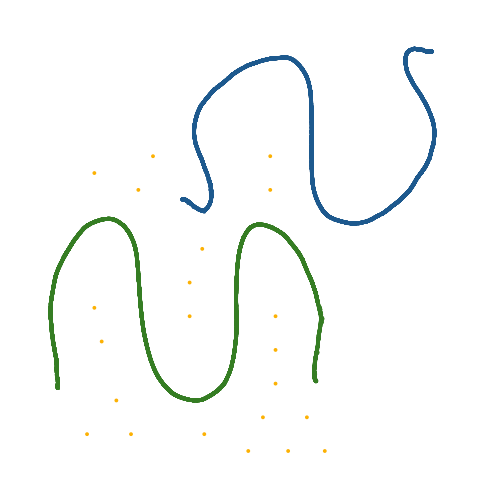

In [86]:
fig,ax= plt.subplots(figsize=(6, 6))
plot_read_graph(ax,graph,meta_df,reference_graph)

In [11]:
##simhash
npz = np.load("/home/miaocj/docker_dir/kNN-overlap-finder/data/evaluation/human/IGH/ONT_R9/kmer_k16/SimHash_TF_nbr_matrix.npz")
vp_nbr = npz['arr_0']

In [138]:
edges_simhash = []
continuity_simhash = []
for k in range(1,21):
    overlap_candidates = get_overlap_candidates(vp_nbr,k,read_ids)
    graph = nx.Graph()
    graph.add_edges_from(overlap_candidates)
    false_edges = []
    for u, v in graph.edges:
        if not reference_graph.has_edge(u, v):
            false_edges.append((u, v))
    graph.remove_edges_from(false_edges)
    edges_simhash.append(graph.size()) 
    component_sizes = [len(x) for x in nx.connected_components(graph)]
    component_sizes.sort(reverse=True)
    component_sizes = np.array(component_sizes)
    node_count = len(graph.nodes)
    N50 = component_sizes[component_sizes.cumsum() >= node_count * 0.5].max()
    continuity = N50/(node_count/2)
    continuity_simhash.append(continuity)

In [ ]:
##绘图
k_values = np.arange(2, 21)
import matplotlib.pyplot as plt
fig,ax= plt.subplots(figsize=(6, 6),dpi=300)
ax.plot(continuity_simhash,label='SimHash')
ax.plot(continuity_minimap,label='Minimap2')
ax.set_xticks([ x for x in k_values if x%2==0]) 
ax.set_xlabel("Number of edges")  
ax.set_ylabel('continuity') 
ax.grid(axis='both', color='k', alpha=0.1) 
ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1))

In [42]:
overlap_candidates = get_overlap_candidates(vp_nbr,17,read_ids) ##记得设置neighbor数目
graph_split = nx.Graph()
graph_split.add_edges_from(overlap_candidates)

false_edges = []
for u, v in graph_split.edges:
    if not reference_graph.has_edge(u, v):
        false_edges.append((u, v))
graph_split.remove_edges_from(false_edges)
component_sizes2 = [len(x) for x in nx.connected_components(graph_split)]


In [43]:
overlap_candidates = get_overlap_candidates(vp_nbr,20,read_ids) ##记得设置neighbor数目
graph_connected = nx.Graph()
graph_connected.add_edges_from(overlap_candidates)

false_edges = []
for u, v in graph_connected.edges:
    if not reference_graph.has_edge(u, v):
        false_edges.append((u, v))
graph_connected.remove_edges_from(false_edges)
component_sizes2 = [len(x) for x in nx.connected_components(graph_connected)]

In [51]:
diff = []
for u,v in list(nx.bridges(graph_connected)):
    if (u,v) not in list(nx.bridges(graph_split)):
        diff.append((u,v)) 

In [52]:
diff

[(11593, 16869), (15685, 6868), (10113, 13073)]

In [50]:
list(nx.bridges(graph_connected))

[(71, 426),
 (4226, 1594),
 (19388, 13826),
 (11314, 7146),
 (3775, 13526),
 (11593, 16869),
 (21914, 7683),
 (15685, 6868),
 (12643, 21928),
 (17371, 21929),
 (7314, 7499),
 (10113, 13073),
 (20069, 18108),
 (18490, 16910),
 (6783, 7297),
 (4111, 13260),
 (1004, 5755),
 (15449, 18155),
 (13907, 12255),
 (11603, 18647),
 (2080, 13449),
 (7479, 14366),
 (6024, 19622),
 (6312, 18245),
 (17459, 6869),
 (18491, 16911),
 (3361, 14453),
 (4170, 21028),
 (7311, 9147),
 (4650, 12860),
 (5490, 13021),
 (12293, 12941)]

In [48]:
len(diff)

34509

In [33]:
r_num ={}
for u,v in graph.edges:
    if u not in r_num.keys():
        r_num[u]=1
    else:
        r_num[u] +=1

In [37]:
r_num

{0: 17,
 1596: 17,
 11664: 19,
 6427: 14,
 6013: 13,
 13515: 16,
 5070: 29,
 11981: 37,
 2060: 20,
 4060: 30,
 8933: 13,
 20086: 29,
 4076: 7,
 7734: 24,
 18364: 18,
 21182: 27,
 13724: 21,
 12606: 7,
 1: 17,
 1597: 17,
 6012: 15,
 11665: 18,
 5071: 27,
 13514: 16,
 8167: 27,
 6426: 12,
 4061: 32,
 2061: 18,
 4077: 8,
 7735: 25,
 3894: 25,
 20087: 31,
 3387: 27,
 3380: 20,
 13725: 30,
 12607: 9,
 2: 18,
 13581: 18,
 14237: 17,
 4716: 17,
 18220: 16,
 6642: 27,
 16123: 25,
 10241: 23,
 16881: 18,
 15192: 23,
 20168: 29,
 8404: 23,
 19414: 23,
 11971: 10,
 2802: 10,
 17516: 31,
 1790: 16,
 18125: 15,
 3: 17,
 13580: 18,
 4717: 17,
 14236: 15,
 18221: 16,
 6643: 27,
 16880: 18,
 8405: 24,
 18124: 17,
 19415: 23,
 16122: 23,
 10240: 24,
 20169: 28,
 15193: 19,
 11970: 8,
 4239: 5,
 2803: 10,
 6320: 26,
 4: 17,
 4425: 17,
 15845: 19,
 5425: 22,
 7353: 13,
 16722: 15,
 18176: 20,
 3211: 13,
 21046: 20,
 14739: 13,
 11039: 23,
 20478: 33,
 18203: 27,
 9742: 22,
 5562: 39,
 10878: 8,
 5206: 11

In [35]:
sorted_num = sorted(r_num.items(), key=lambda x:x[1])

In [39]:
singleton = {k:v for k,v in r_num.items() if v ==1}

In [40]:
len(singleton)

1258

In [27]:
r_num ={}
for u,v in graph.edges:
    if u not in r_num.keys():
        r_num[u]=1
    else:
        r_num[u] +=1

In [28]:
r_num

{0: 17,
 1596: 17,
 11664: 19,
 6427: 14,
 6013: 13,
 13515: 16,
 5070: 29,
 11981: 37,
 2060: 20,
 4060: 30,
 8933: 13,
 20086: 29,
 4076: 7,
 7734: 24,
 18364: 18,
 21182: 27,
 13724: 21,
 12606: 7,
 1: 17,
 1597: 17,
 6012: 15,
 11665: 18,
 5071: 27,
 13514: 16,
 8167: 27,
 6426: 12,
 4061: 32,
 2061: 18,
 4077: 8,
 7735: 25,
 3894: 25,
 20087: 31,
 3387: 27,
 3380: 20,
 13725: 30,
 12607: 9,
 2: 18,
 13581: 18,
 14237: 17,
 4716: 17,
 18220: 16,
 6642: 27,
 16123: 25,
 10241: 23,
 16881: 18,
 15192: 23,
 20168: 29,
 8404: 23,
 19414: 23,
 11971: 10,
 2802: 10,
 17516: 31,
 1790: 16,
 18125: 15,
 3: 17,
 13580: 18,
 4717: 17,
 14236: 15,
 18221: 16,
 6643: 27,
 16880: 18,
 8405: 24,
 18124: 17,
 19415: 23,
 16122: 23,
 10240: 24,
 20169: 28,
 15193: 19,
 11970: 8,
 4239: 5,
 2803: 10,
 6320: 26,
 4: 17,
 4425: 17,
 15845: 19,
 5425: 22,
 7353: 13,
 16722: 15,
 18176: 20,
 3211: 13,
 21046: 20,
 14739: 13,
 11039: 23,
 20478: 33,
 18203: 27,
 9742: 22,
 5562: 39,
 10878: 8,
 5206: 11

In [19]:
type(reference_graph.edges())

networkx.classes.reportviews.EdgeView

In [11]:
component_sizes = [len(x) for x in nx.connected_components(graph)]
component_sizes.sort(reverse=True)
component_sizes = np.array(component_sizes)
node_count = len(graph.nodes)
N50 = component_sizes[component_sizes.cumsum() >= node_count * 0.5].max()
continuity = N50/(node_count/2)
continuity

2.0

In [95]:
N50

7222

In [96]:
component_sizes

array([7223, 7222, 3737, 3736,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1])

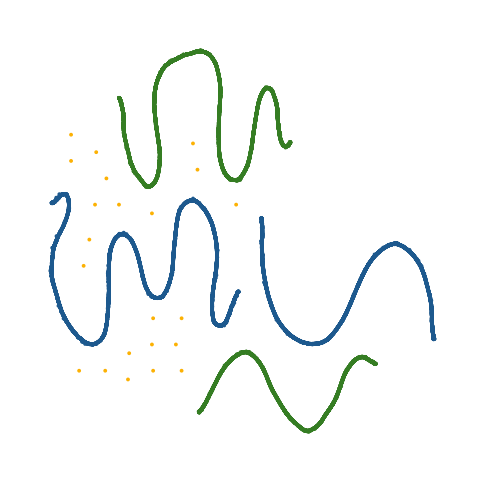

In [16]:
fig,ax= plt.subplots(figsize=(6, 6))
plot_read_graph(ax,graph,meta_df,reference_graph) 

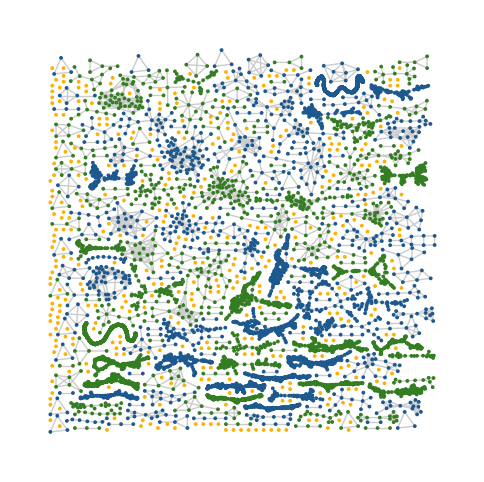

In [14]:
##simhash n_neighbor = 6
fig,ax= plt.subplots(figsize=(6, 6))
plot_read_graph(ax,graph,meta_df,reference_graph)

In [13]:

def get_graphviz_layout(graph, method="neato", figsize=(8, 6), seed=43, **kw):
    fig_width, fig_height = figsize
    graph_attributes = dict(
        dim=2, dimen=2, size=f'"{fig_width},{fig_height}"', start=seed, smoothing="none"
    )
    graph_attributes.update(kw)
    args = " ".join(f"-G{key}={value}" for key, value in graph_attributes.items())
    pos = nx.nx_agraph.graphviz_layout(graph, prog=method, args=args)
    return pos
def plot_read_graph(
    ax,
    query_graph: OverlapGraph | None = None,
    metadata: pd.DataFrame | None = None,
    reference_graph: OverlapGraph | None = None,
    *,
    layout_method="sfdp",
    pos=None,
    figsize=(8, 6),
    node_size=3,
    seed=43,
):
    if query_graph is not None:
        g = query_graph
    elif query_graph is None and reference_graph is not None:
        g = reference_graph
    else:
        raise TypeError()

    # Edge colors
    GRAY = (0.8, 0.8, 0.8, 1)
    LIGHT_GRAY = (0.9, 0.9, 0.9, 1)
    RED = (1, 0.1, 0.1, 1)

    edge_colors = []
    for edge, attr in g.edges.items(): 
        color = "k"
        k1, k2 = edge

        if attr.get("redundant", False):
            color = LIGHT_GRAY
        elif reference_graph is not None and not reference_graph.has_edge(k1, k2):
            color = RED
        else:
            color = GRAY
        edge_colors.append(color)

    BLUE = (29 / 255, 89 / 255, 142 / 255, 1)
    GREEN = (53 / 255, 125 / 255, 35 / 255, 1)
    ORANGE = (252 / 255, 177 / 255, 3 / 255, 1)

    # Node colors
    node_colors = []
    for node in g.nodes:
        if len(g[node]) == 0:
            color = ORANGE
        elif metadata is None:
            color = BLUE
        elif metadata.at[node, "reference_strand"] == "+":
            color = BLUE
        elif metadata.at[node, "reference_strand"] == "-":
            color = GREEN
        else:
            raise ValueError()
        node_colors.append(color)

    # Layout
    if layout_method == "umap":
        pos = get_umap_layout(graph=g)
    else:
        pos = get_graphviz_layout(
            graph=g, figsize=figsize, seed=seed, method=layout_method
        )

    # Plot
    nx.draw_networkx(
        g,
        ax=ax,
        pos=pos,
        with_labels=False,
        node_size=node_size,
        edge_color=edge_colors,
        node_color=node_colors,
    )
    ax.axis("off")


In [76]:
for x in nx.connected_components(graph):
    print(len(x))

12926


In [39]:
read_ids

array([    0,     1,     2, ..., 12923, 12924, 12925])

In [84]:

g = ig.Graph()
g = ig.Graph(n=len(read_ids), edges=overlap_candidates)
g.delete_edges(false_edges)

In [90]:

component_sizes3 = [len(x) for x in g.connected_components()]

In [91]:
component_sizes3

[12913, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [47]:
ref_g = ig.Graph()
ref_g = ig.Graph(n=len(read_ids), edges=reference_graph.edges())

In [52]:
BLUE = (29 / 255, 89 / 255, 142 / 255, 1)
GREEN = (53 / 255, 125 / 255, 35 / 255, 1)
ORANGE = (252 / 255, 177 / 255, 3 / 255, 1)

node_colors = []
for node in read_ids:
    if meta_df.at[node, "reference_strand"] == "+":
        color = BLUE
    elif meta_df.at[node, "reference_strand"] == "-":
        color = GREEN
    else:
        raise ValueError()
    node_colors.append(color)
g.vs["color"] = node_colors

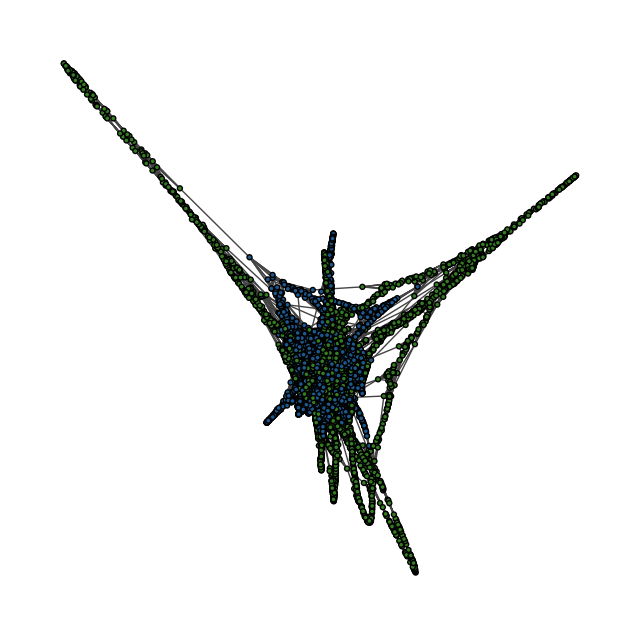

In [58]:
fig, ax = plt.subplots(figsize=(8, 8))
layout = g.layout("large")
ig.plot(g, layout=layout, target=ax,vertex_size=5,edge_width=1,edgecolor='none')

In [ ]:

# Edge colors
GRAY = (0.8, 0.8, 0.8, 1)
LIGHT_GRAY = (0.9, 0.9, 0.9, 1)
RED = (1, 0.1, 0.1, 1)

edge_colors = []
for edge, attr in g.edges.items(): 
    color = "k"
    k1, k2 = edge

    if attr.get("redundant", False):
        color = LIGHT_GRAY
    elif reference_graph is not None and not reference_graph.has_edge(k1, k2):
        color = RED
    else:
        color = GRAY
    edge_colors.append(color)



In [15]:
df_rows = []
for k in k_values:
    graph = OverlapGraph.from_neighbor_indices(
        neighbor_indices=vp_nbr,
        n_neighbors=k,
        read_ids=read_ids,
        require_mutual_neighbors=False,
    )
    graph_stats = get_overlap_statistics(query_graph=graph, reference_graph=reference_graph)
    stats = { "n_neighbors": k}
    stats = {"description":'method1', "n_neighbors": k, "repeat_time": 1,
                **graph_stats}
    df_rows.append(stats)
df = pd.DataFrame(df_rows)

In [33]:
np.random.seed(seed=42)

dimension = 32 # 32 bytes are 256 bit dimensional vectos
num_points = 2021
data = np.random.normal(scale=255, loc=0, size=(num_points, dimension)).astype(dtype=np.uint8)

num_queries = 8
queries = np.random.normal(scale=255, loc=0, size=(num_queries, dimension)).astype(dtype=np.uint8)

vptree = pynear.BKTreeBinaryIndex()
vptree.set(data)

# To search using maximum threshold use dimension * 8 (the maximum distance) or set any other threshold
indices, distances, keys = vptree.find_threshold(data, dimension * 8)

In [45]:
indices[1] == indices[2]

True

In [59]:
nbrs = NearestNeighbors(n_neighbors=21, algorithm='auto', metric=hamming_distance)
nbrs.fit(reads_simhash_array)  
indices = nbrs.kneighbors(reads_simhash_array,return_distance=False)
nbr_indices = indices[:, 1:]

In [29]:
df_rows = []
for k in k_values:
    graph = OverlapGraph.from_neighbor_indices(
        neighbor_indices=nbr_indices,
        n_neighbors=k,
        read_ids=read_ids,
        require_mutual_neighbors=False,
    )
    graph_stats = get_overlap_statistics(query_graph=graph, reference_graph=reference_graph)
    stats = { "n_neighbors": k}
    stats = {"description":'method2', "n_neighbors": k, "repeat_time": 1,
                **graph_stats}
    df_rows.append(stats)
df = pd.DataFrame(df_rows)

In [48]:
nbr_indices

array([[11900,  1764,  5988, ..., 12076,  6839,  1711],
       [11901,  5989,  5504, ...,  8245,  3398,  3230],
       [  598, 12019,  2068, ...,  5981,  4399,  6843],
       ...,
       [ 8636,  9267,  8123, ...,  4184, 12577,  5141],
       [ 1890,  3291, 11969, ...,  9363, 11337,  3040],
       [ 1891,  3290, 11968, ...,  9362, 11336,  3041]])

In [24]:
len(vptree_indices[1])

20

In [18]:
np.random.seed(seed=42)

dimension = 32 # 32 bytes are 256 bit dimensional vectos
num_points = 2021
data = np.random.normal(scale=255, loc=0, size=(num_points, dimension)).astype(dtype=np.uint8)

num_queries = 8
queries = np.random.normal(scale=255, loc=0, size=(num_queries, dimension)).astype(dtype=np.uint8)

k = 2

vptree = pynear.VPTreeBinaryIndex()
vptree.set(data)
vptree_indices, vptree_distances = vptree.searchKNN(queries, k)

In [20]:
data

array([[126, 221, 165, ..., 182, 103, 216],
       [253, 243, 209, ..., 209, 230, 207],
       [207,  89, 238, ..., 173, 157, 139],
       ...,
       [ 79, 145, 223, ...,   0, 162,  59],
       [ 68,   9,  84, ...,  30, 218,  44],
       [ 34, 107, 189, ...,  17,  79, 247]], dtype=uint8)

In [ ]:
import vptree
tree = vptree.VPTree(reads_simhash_array, hamming_distance)
tree.get_n_nearest_neighbors(list(reads_simhash_array[1]), 10)

In [56]:


#df_tfidf.to_csv('/home/miaocj/docker_dir/kNN-overlap-finder/data/evaluation/human/HLA/ONT_R9/kmer_k16/SimHash_None_None_overlap_stat.tsv',sep='\t')

In [12]:
pip install vptree

  Using cached vptree-1.3.tar.gz (4.4 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for vptree: filename=vptree-1.3-py3-none-any.whl size=4546 sha256=5cc08ad90292e727e0c327e5ad689a94de66da6853727abeac950b9ffbd385d8
  Stored in directory: /home/miaocj/.cache/pip/wheels/3a/eb/ca/904b67530bad0ab02a61978e03549e80bfb1ae07363edb3aab
Successfully built vptree
Note: you may need to restart the kernel to use updated packages.


In [30]:
reads_simhash_array

array([[0, 0, 1, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 1, 1, ..., 1, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 1, 0, 1]])

In [36]:
points = np.random.randn(20000, 10)
query = [.5] * 10
reads_simhash_array[0]

array([0, 0, 1, ..., 1, 0, 0])

In [47]:
len(reads_simhash_array)

12926

In [ ]:
import numpy as np
import vptree

# Define distance function.
def euclidean(p1, p2):
  return np.sqrt(np.sum(np.power(p2 - p1, 2)))

# Generate some random points.
points = np.random.randn(12926, 3200)
query = [.5] * 3200

# Build tree in O(n log n) time complexity.
tree = vptree.VPTree(points, hamming_distance)

# Query single point.
tree.get_nearest_neighbor(query)

In [57]:
##法一 ：哈希长度为1028
df
df.to_csv('/home/miaocj/docker_dir/kNN-overlap-finder/data/evaluation/human/HLA/ONT_R9/kmer_k16/SimHash_method1_overlap_stat.tsv',sep='\t')

In [50]:
df

,description,n_neighbors,repeat_time,precision,nr_precision,recall,nr_recall,singleton_count,singleton_fraction,N50,component_sizes
0,SimHash_TF-IDF,2,100,0.959684,0.290254,0.059900,0.232711,565,0.043710,455,"[857, 725, 718, 686, 665, 615, 557, 514, 463, ..."
1,SimHash_TF-IDF,3,100,0.953179,0.260759,0.086906,0.305389,457,0.035355,1514,"[3303, 2452, 1514, 1178, 1063, 880, 596, 588, ..."
2,SimHash_TF-IDF,4,100,0.947717,0.237915,0.113280,0.365287,394,0.030481,6223,"[6362, 6223, 134, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1..."
3,SimHash_TF-IDF,5,100,0.942152,0.219366,0.138751,0.414979,363,0.028083,6366,"[6366, 6366, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, ..."
4,SimHash_TF-IDF,6,100,0.936710,0.205125,0.163604,0.460199,336,0.025994,6369,"[6373, 6369, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, ..."
5,SimHash_TF-IDF,7,100,0.931507,0.193302,0.188038,0.501226,320,0.024756,6376,"[6377, 6376, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, ..."
6,SimHash_TF-IDF,8,100,0.926592,0.182611,0.211843,0.536279,305,0.023596,6379,"[6381, 6379, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, ..."
7,SimHash_TF-IDF,9,100,0.921660,0.173825,0.235100,0.569552,289,0.022358,6382,"[6383, 6382, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, ..."
8,SimHash_TF-IDF,10,100,0.916555,0.165750,0.257791,0.598829,280,0.021662,6385,"[6391, 6385, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
9,SimHash_TF-IDF,11,100,0.911067,0.158549,0.279779,0.625415,270,0.020888,6385,"[6393, 6385, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [ ]:
ref_reads_simhash_array = get_simhash(ref_read_features,hash_table)

nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto', metric=hamming_distance)
nbrs.fit(ref_reads_simhash_array)
indices = nbrs.kneighbors(que_reads_simhash_array,return_distance=False)
print("done\nevaluates")

In [35]:
def _hash(kmer_index: int, seed: int) -> np.ndarray:  
    hash_value = mmh3.hash(str(kmer_index), seed=seed)
    binary_string = "{0:032b}".format(hash_value & 0xFFFFFFFF)  
    hash_array = np.array([int(x) for x in binary_string], dtype=np.int8) 
    hash_array = np.where(hash_array == 0, -1, 1)  
    return hash_array  

def _get_table(
    read_features: list,  
    feature_matrix: list,
    *,
    seed: int,
    tf:bool,
    idf:bool,
    repeat=100) -> Mapping[int,list]:  
    
    rng = np.random.default_rng(seed)  
    hash_seeds = rng.integers(low=0, high=2**32 - 1, size=repeat, dtype=np.uint64)  

    kmer_num = feature_matrix.shape[1]
    hash_table = np.empty((kmer_num,repeat,32),dtype=np.int8)  
    for flag,seed in enumerate(hash_seeds):
        for kmer_index in range(kmer_num):
            hash_table[kmer_index,flag,:]=_hash(kmer_index, seed=seed)
            new_hash_table=np.reshape(hash_table,(kmer_num,3200))
    return new_hash_table

def _get_simhash(
    read_features: list,  
    feature_matrix: list,
    hash_table,
    *,
    seed: int,
    tf:bool,
    idf:bool,
    repeat=100) -> Mapping[int,list]:  
    all_read_simhash = []
    if idf == True:
        nested_list = list(read_features.values())
        unrongh_nest = [list(set(sublist)) for sublist in nested_list]  
        merged_list = list(chain.from_iterable(unrongh_nest)) 
        count = Counter(merged_list)
        sorted_counts = dict(sorted(count.items(), key=lambda x: x[0]))  
        times = np.array(list(sorted_counts.values()))
        x = len(read_features)
        arr = np.full(feature_matrix.shape[1],x)  
        idf = np.log(arr/times)
        weighted_hash_table = hash_table*idf[:, np.newaxis]
    else:
        weighted_hash_table = hash_table
    if tf == False:
        read_features = {k:list(set(v)) for k,v in read_features.items()}

    for read_kmer in read_features.values():
        one_read_hash = np.sum(weighted_hash_table[read_kmer,:],axis=0)
        simhash = np.where(one_read_hash > 0, 1, 0)
        all_read_simhash.append(simhash)
    reads_simhash_array = np.array(all_read_simhash)

    return reads_simhash_array 

hash_table = _get_table(read_features,feature_matrix,seed = 15232,tf = False,idf=False,repeat=100)
print("1")
reads_simhash_array = _get_simhash(read_features,feature_matrix,hash_table,seed = 15232,tf = True,idf=False,repeat=100)

In [6]:
def _hash(kmer_index: int, seed: int) -> np.ndarray:  
    hash_value = mmh3.hash(str(kmer_index), seed=seed)
    binary_string = "{0:032b}".format(hash_value & 0xFFFFFFFF)  
    hash_array = np.array([int(x) for x in binary_string], dtype=np.int8) 
    hash_array = np.where(hash_array == 0, -1, 1)  
    return hash_array  
def mp_get_hashtable(  
    feature_matrix: list,   
    repeat: int,   
    seed: int,
    processes:int,) -> Mapping[int,list]:  
      
    rng = np.random.default_rng(seed)  
    hash_seeds = rng.integers(low=0, high=2**32 - 1, size=repeat, dtype=np.uint64)  
    kmer_num = feature_matrix.shape[1]
    hash_table = np.empty((kmer_num,repeat,32),dtype=np.int8) 

    with sharedmem.MapReduce(np=processes) as pool:

        def work(i):
            seed = hash_seeds[i]
            result = np.empty((kmer_num,32), dtype=np.int8) 
            for kmer_index in range(kmer_num):
                result[kmer_index,:]=_hash(kmer_index, seed=seed)
            return i,result

        def reduce(i, result):
            hash_table[:,i,:] = result            

        pool.map(work, range(repeat), reduce=reduce)
    return hash_table
hash_table = mp_get_hashtable(read_features,feature_matrix,15232,10)

In [19]:
one_read_hash = np.sum(hash_table[list(read_features.values())[0],:,:],axis=0)
hash_table

In [26]:
hash_table.shape

In [34]:
kmer_num = feature_matrix.shape[1]
hash_table=np.reshape(hash_table,(kmer_num,3200))

In [30]:
len(new_hash[1])

In [18]:
def get_read_intervals(meta_df):
    read_intervals = {
        i: [GenomicInterval(strand, start, end)]
        for i, strand, start, end in zip(
            meta_df.index,
            meta_df["reference_strand"],
            meta_df["reference_start"],
            meta_df["reference_end"],
        )
    }
    return read_intervals

read_intervals = get_read_intervals(meta_df)

reference_graph = OverlapGraph.from_intervals(read_intervals)
nr_edges = set((node_1, node_2) for node_1, node_2, data in reference_graph.edges(data=True) if not data['redundant'])
connected_component_count = len(list(nx.connected_components(reference_graph)))
len(reference_graph.nodes), len(reference_graph.edges), len(nr_edges), connected_component_count

In [19]:
read_ids = np.array(list(read_features))

In [20]:
def _hash(kmer_index: int, seed: int) -> np.ndarray:  
    hash_value = mmh3.hash(str(kmer_index), seed=seed)
    binary_string = "{0:032b}".format(hash_value & 0xFFFFFFFF)  
    hash_array = np.array([int(x) for x in binary_string], dtype=np.int32) 
    hash_array = np.where(hash_array == 0, -1, 1)  
    return hash_array  

def mp_get_hashtable(  
    feature_matrix: list,   
    repeat: int,   
    seed: int,
    processes:int,) -> Mapping[int,list]:  
      
    rng = np.random.default_rng(seed)  
    hash_seeds = rng.integers(low=0, high=2**32 - 1, size=repeat, dtype=np.uint64)  
    kmer_num = feature_matrix.shape[1]
    hash_table = np.empty((kmer_num,repeat),dtype=object) 

    with sharedmem.MapReduce(np=processes) as pool:

        def work(i):
            seed = hash_seeds[i]
            result = np.empty(kmer_num, dtype=object) 
            for kmer_index in range(kmer_num):
                result[kmer_index]=_hash(kmer_index, seed=seed)
            return i,result

        def reduce(i, result):
            hash_table[:,i] = result            

        pool.map(work, range(repeat), reduce=reduce)
    return hash_table

def hamming_distance(x, y):  
    return np.count_nonzero(x != y)

## multi-process calculate simhash value
def mp_get_simhash(
    read_features: list,  
    feature_matrix: list,
    hash_table,
    tf:bool,
    idf:bool,
    processes:int,):
    
    if idf == True:
        nested_list = list(read_features.values())
        unrongh_nest = [list(set(sublist)) for sublist in nested_list]  
        merged_list = list(chain.from_iterable(unrongh_nest)) 
        count = Counter(merged_list)
        sorted_counts = dict(sorted(count.items(), key=lambda x: x[0]))  
        times = np.array(list(sorted_counts.values()))
        x = len(read_features)
        arr = np.full(feature_matrix.shape[1],x)  
        idf = np.log(arr/times)
        hash_table = hash_table*idf[:, np.newaxis]
    if tf == False:
        read_features = {k:list(set(v)) for k,v in read_features.items()} 

       
    reads_simhash_array = np.empty((len(read_features),hash_table.shape[1]*32),dtype=object)
    with sharedmem.MapReduce(np=processes) as pool:

        def work(i):
            read_kmer = list(read_features.values())[i]
            one_read_hash = np.sum(hash_table[read_kmer,:],axis=0)
            conc_hash = np.concatenate(one_read_hash)
            result = np.where(conc_hash > 0, 1, 0)
            return i,result

        def reduce(i, result):
            reads_simhash_array[i,:] = result            
        pool.map(work, range(len(read_features)), reduce=reduce)
    return reads_simhash_array

In [21]:
hash_table = mp_get_hashtable(feature_matrix,repeat =100, seed = 4829,processes=12)
print('hashtable established')

In [16]:
df_tfidf

In [111]:
df_tfidf

In [ ]:
import numpy as np  
import collections  
from typing import Mapping  
from sklearn.neighbors import NearestNeighbors  
from scipy.spatial.distance import hamming  
import mmh3

for repeat in [100]:
    print(repeat)
    concat_simhash = _get_simhash(read_features,feature_matrix,repeat =repeat, seed = 4829,tf = True,idf = True)
    nbrs = NearestNeighbors(n_neighbors=21, algorithm='auto', metric=hamming_distance)
    nbrs.fit(concat_simhash)  
    indices = nbrs.kneighbors(concat_simhash,return_distance=False)
    nbr_indices = indices[:, 1:]

    for k in k_values:
        graph = OverlapGraph.from_neighbor_indices(
            neighbor_indices=nbr_indices,
            n_neighbors=k,
            read_ids=read_ids,
            require_mutual_neighbors=False,
        )
        graph_stats = get_overlap_statistics(query_graph=graph, reference_graph=reference_graph)
        stats = { "n_neighbors": k}
        stats = {"description":'SimHash', "n_neighbors": k, "repeat_time": repeat,
                    **graph_stats}
        df_rows.append(stats)
    df = pd.DataFrame(df_rows)

In [ ]:
repeat = 100

def _hash(kmer_index: int, seed: int) -> np.ndarray:  
    hash_value = mmh3.hash(str(kmer_index), seed=seed)
    binary_string = "{0:032b}".format(hash_value & 0xFFFFFFFF)  
    hash_array = np.array([int(x) for x in binary_string], dtype=np.int32) 
    hash_array = np.where(hash_array == 0, -1, 1)  
    return hash_array  

all_read_simhash = []
rng = np.random.default_rng(4829)  
hash_seeds = rng.integers(low=0, high=2**32 - 1, size=repeat, dtype=np.uint64)
kmer_num = feature_matrix.shape[1]
hash_table = np.empty((kmer_num,repeat),dtype=object)  
for flag,seed in enumerate(hash_seeds):
    print(flag)
    kmer_hash_indice = {} 
    for kmer_index in range(kmer_num):
        hash_table[kmer_index,flag]=_hash(kmer_index, seed=seed)
new_hash = hash_table*idf[:, np.newaxis]

for read_ind,read_kmer in read_features.items():
    one_read_hash = np.sum(new_hash[read_kmer,:],axis=0)
    conc_hash = np.concatenate(one_read_hash)
    simhash = np.where(conc_hash > 0, 1, 0)
    all_read_simhash.append(simhash)
reads_simhash_array = np.array(all_read_simhash)

In [ ]:
reads_simhash_array

In [ ]:
nbrs = NearestNeighbors(n_neighbors=21, algorithm='auto', metric=hamming_distance)
nbrs.fit(reads_simhash_array)  
indices = nbrs.kneighbors(reads_simhash_array,return_distance=False)
nbr_indices = indices[:, 1:]

read_ids = np.array(list(read_features))
k_values = np.arange(2, max_n_neighbors + 1)
df_rows = []

for k in k_values:
    graph = OverlapGraph.from_neighbor_indices(
        neighbor_indices=nbr_indices,
        n_neighbors=k,
        read_ids=read_ids,
        require_mutual_neighbors=False,
    )
    graph_stats = get_overlap_statistics(query_graph=graph, reference_graph=reference_graph)
    stats = { "n_neighbors": k}
    stats = {"description":'SimHash', "n_neighbors": k, "repeat_time": repeat,
                **graph_stats}
    df_rows.append(stats)
df = pd.DataFrame(df_rows)

In [ ]:
##带tf idf 初始版本
def _hash(kmer_index: int, seed: int) -> np.ndarray:  
    hash_value = mmh3.hash(str(kmer_index), seed=seed)
    binary_string = "{0:032b}".format(hash_value & 0xFFFFFFFF)  
    hash_array = np.array([int(x) for x in binary_string], dtype=np.int32) 
    hash_array = np.where(hash_array == 0, -1, 1)  
    return hash_array  

def _get_simhash(  
    read_features: list,  
    feature_matrix: list,   
    repeat: int,   
    seed: int,
    tf:bool,
    idf:bool,) -> Mapping[int,list]:  
      
    rng = np.random.default_rng(seed)  
    hash_seeds = rng.integers(low=0, high=2**32 - 1, size=repeat, dtype=np.uint64)  
  
    all_read_simhash = []
    kmer_num = feature_matrix.shape[1]
    hash_table = np.empty((kmer_num,repeat),dtype=object)  
    for flag,seed in enumerate(hash_seeds):
        for kmer_index in range(kmer_num):
            hash_table[kmer_index,flag]=_hash(kmer_index, seed=seed)

    if idf == True:
        nested_list = list(read_features.values())
        unrongh_nest = [list(set(sublist)) for sublist in nested_list]  
        merged_list = list(chain.from_iterable(unrongh_nest)) 
        count = Counter(merged_list)
        sorted_counts = dict(sorted(count.items(), key=lambda x: x[0]))  
        times = np.array(list(sorted_counts.values()))
        x = len(read_features)
        arr = np.full(feature_matrix.shape[1],x)  
        idf = np.log(arr/times)
        hash_table = hash_table*idf[:, np.newaxis]
    if tf == False:
        read_features = {k:set(v) for k,v in read_features}

    for read_kmer in read_features.values():
        one_read_hash = np.sum(hash_table[read_kmer,:],axis=0)
        conc_hash = np.concatenate(one_read_hash)
        simhash = np.where(conc_hash > 0, 1, 0)
        all_read_simhash.append(simhash)
    reads_simhash_array = np.array(all_read_simhash)
  
    return reads_simhash_array 

def hamming_distance(x, y):  
    return np.count_nonzero(x != y)

In [ ]:
new[3][1]

In [ ]:
df

In [ ]:
##32位，70个repeat
import numpy as np  
import collections  
from typing import Mapping  
from sklearn.neighbors import NearestNeighbors  
from scipy.spatial.distance import hamming  
import mmh3  

def _hash(kmer_index: int, seed: int) -> np.ndarray:  
    hash_value = mmh3.hash(str(kmer_index), seed=seed)  
    binary_string = "{0:032b}".format(hash_value & 0xFFFFFFFF)  
    hash_array = np.array([int(x) for x in binary_string], dtype=np.int32)  
    return hash_array  

def _get_simhash(  
    read_features: list,  
    feature_matrix: list,   
    repeat: int,   
    seed: int) -> Mapping[int,list]:  

    hash_seeds = np.array(range(repeat))
    kmer_num = feature_matrix.shape[1]
    kmer_index = np.array(range(kmer_num))

    table = []
    for seed in hash_seeds:
        prime1 = 2654435761  # A large prime number
        prime2 = 0x27d4eb2d  # Another large prime, often used in hashing
        hash_value = (kmer_index * prime1) ^ (seed * prime2)
        hash_t = hash_value % (2**32)
        binary_matrix = np.vectorize(np.binary_repr)(hash_t, width=32)
        one_repear_table = np.array([list(row) for row in binary_matrix.flatten()])
        table.append(one_repear_table.astype(int))
    hash_table = np.hstack(table)

    all_read_simhash = []
    for read_ind,read_kmer in read_features.items():
        one_read_hash = np.sum(hash_table[read_kmer,:],axis=0)
        simhash = np.where(conc_hash > 0, 1, 0)
        all_read_simhash.append(simhash)
    concat_simhash = np.array(all_read_simhash)
    return concat_simhash 

def hamming_distance(x, y):  
    return np.count_nonzero(x != y)

dfs = []
for repeat in range(20,110,10):
    print(repeat)
    concat_simhash = _get_simhash(read_features,feature_matrix,repeat =repeat, seed = 4829)
    nbrs = NearestNeighbors(n_neighbors=21, algorithm='auto', metric=hamming_distance)
    nbrs.fit(concat_simhash)  
    indices = nbrs.kneighbors(concat_simhash,return_distance=False)
    nbr_indices = indices[:, 1:]

    for k in k_values:
        graph = OverlapGraph.from_neighbor_indices(
            neighbor_indices=nbr_indices,
            n_neighbors=k,
            read_ids=read_ids,
            require_mutual_neighbors=False,
        )
        graphs[k] = graph

    df_rows = []
    for k in k_values:
        graph = graphs[k]
        graph_stats = get_overlap_statistics(query_graph=graph, reference_graph=reference_graph)
        stats = { "n_neighbors": k}
        stats = {"description":'SimHash', "n_neighbors": k, "repeat_time": repeat,
                    **graph_stats}
        df_rows.append(stats)
    df = pd.DataFrame(df_rows)
    dfs.append(df)
    
new = pd.concat(dfs)
new.to_csv('/home/miaocj/docker_dir/test_simhash.csv',sep='\t')

In [ ]:
new

In [ ]:
meta_df = pd.read_table(tsv_path).iloc[:MAX_SAMPLE_SIZE, :].reset_index()
read_indices = {read_name: read_id for read_id, read_name in meta_df['read_name'].items()}
feature_matrix = sp.sparse.load_npz(npz_path)[meta_df.index, :]

with gzip.open(json_path, "rt") as f:
    read_features = json.load(f)
    read_features = {i: read_features[i] for i in meta_df.index}

feature_weights = {i: 1 for i in range(feature_matrix.shape[1])}

In [ ]:
read_ids = np.array(list(read_features))
graphs = collections.defaultdict(dict)
k_values = np.arange(2, max_n_neighbors + 1)

for k in k_values:
    graph = OverlapGraph.from_neighbor_indices(
        neighbor_indices=nbr_indices,
        n_neighbors=k,
        read_ids=read_ids,
        require_mutual_neighbors=False,
    )
    graphs[k] = graph

In [ ]:
df_rows = []

for k in k_values:
    graph = graphs[k]
    graph_stats = get_overlap_statistics(query_graph=graph, reference_graph=reference_graph)
    stats = { "n_neighbors": k}
    stats = {"description":'SimHash', "n_neighbors": k, 
                 **graph_stats}
    df_rows.append(stats)
df = pd.DataFrame(df_rows)

In [ ]:
##70
df

In [ ]:
##40
df

In [ ]:
##20
df

测试hash方法

In [ ]:
import hashlib

def simhash(features):
  
  # Generate a hash for each feature
  hashes = [hashlib.sha1(feature).hexdigest() for feature in features]
  
  # Combine the feature hashes to produce the final simhash
  concatenated_hash = ''.join(hashes)
  simhash = hashlib.sha1(concatenated_hash).hexdigest()
  
  return simhash

In [ ]:
x

In [ ]:
pip install xxhash

In [ ]:
import xxhash
x = np.random.rand(1024 * 1024 * 16)
h = xxhash.xxh64()
h.update(x); h.intdigest(); h.reset()

In [ ]:
x

In [ ]:
## 64位， 40个repeat
import numpy as np  
import collections  
from typing import Mapping  
from sklearn.neighbors import NearestNeighbors  
from scipy.spatial.distance import hamming  
import mmh3  

def _hash(kmer_index: int, seed: int) -> np.ndarray:  
    hash_value = mmh3.hash(str(kmer_index), seed=seed)  
    binary_string = "{0:064b}".format(hash_value & 0xFFFFFFFFFFFFFFFF)
    hash_array = np.array([int(x) for x in binary_string], dtype=np.int32)  
    return hash_array  

def _get_simhash(  
    read_features: list,  
    feature_matrix: list,   
    repeat: int,   
    seed: int) -> Mapping[int,list]:  
      
    rng = np.random.default_rng(seed)  
    hash_seeds = rng.integers(low=0, high=2**32 - 1, size=repeat, dtype=np.uint64)  
  
    repeat_all_read_hash = []  
    for s in hash_seeds:  
        print(s)
        kmer_hash_indice = {}  
        for kmer_index in range(feature_matrix.shape[1]):  
            kmer_index_str = str(kmer_index)  
            hash_list = _hash(kmer_index_str, seed=s)  
            kmer_hash_indice[kmer_index] = hash_list  
  
        all_read_simhash = []  
        for features in read_features.values():  
            feature_count = dict(collections.Counter(features))  
            one_read_hash = []  
            for indice, count in feature_count.items():  
                hash_list = kmer_hash_indice[indice]
                hash_list = np.where(hash_list == 0, -1, hash_list) 
                weighted_hash_list = hash_list * count  
                one_read_hash.append(weighted_hash_list)  
            one_read_hash_array = np.array(one_read_hash)  
            hash_sum = np.sum(one_read_hash_array, axis=0)   
            simhash_value = np.where(hash_sum > 0, 1, 0)  
            all_read_simhash.append(simhash_value)  
  
        repeat_all_read_hash.append(all_read_simhash)  
  
    concat_simhash = np.concatenate(repeat_all_read_hash, axis=1)  
  
    return concat_simhash 

concat_simhash = _get_simhash(read_features,feature_matrix,repeat = 40, seed = 4829)
def hamming_distance(x, y):  
    return np.count_nonzero(x != y)
nbrs = NearestNeighbors(n_neighbors=21, algorithm='auto', metric=hamming_distance)
nbrs.fit(concat_simhash)  
indices = nbrs.kneighbors(concat_simhash,return_distance=False)
nbr_indices = indices[:, 1:]


In [ ]:
rng = np.random.default_rng(seed)
beta = rng.uniform(0, 1, (feature_count, dimension_count))
x = rng.uniform(0, 1, (feature_count, dimension_count))
u1 = rng.uniform(0, 1, (feature_count, dimension_count))
u2 = rng.uniform(0, 1, (feature_count, dimension_count))

for j_sample in range(0, sample_count):
    feature_indices = sparse.find(data[:, j_sample] > 0)[0]
    gamma = -np.log(np.multiply(u1[feature_indices, :], u2[feature_indices, :]))
    t_matrix = np.floor(
        np.divide(
            matlib.repmat(
                np.log(data[feature_indices, j_sample].todense()),
                1,
                dimension_count,
            ),
            gamma,
        )
        + beta[feature_indices, :]
    )
    y_matrix = np.exp(np.multiply(gamma, t_matrix - beta[feature_indices, :]))
    a_matrix = np.divide(
        -np.log(x[feature_indices, :]),
        np.divide(y_matrix, u1[feature_indices, :]),
    )

In [ ]:
rng = np.random.default_rng(12)

In [ ]:
##建立hash矩阵
import numpy as np  
import collections  
from typing import Mapping  
from sklearn.neighbors import NearestNeighbors  
from scipy.spatial.distance import hamming  
import mmh3  

def _hash(kmer_index: int, seed: int) -> np.ndarray:  
    hash_value = mmh3.hash(str(kmer_index), seed=seed)  
    binary_string = "{0:032b}".format(hash_value & 0xFFFFFFFF)  
    hash_array = np.array([int(x) for x in binary_string], dtype=np.int32)  
    return hash_array  

def _get_simhash(  
    read_features: list,  
    feature_matrix: list,   
    repeat: int,   
    seed: int) -> Mapping[int,list]:  
      
    rng = np.random.default_rng(seed)  
    hash_seeds = rng.integers(low=0, high=2**32 - 1, size=repeat, dtype=np.uint64)  
  
    repeat_all_read_hash = []  
    hash_table = np.empty((repeat,feature_matrix.shape[1]))  
    for s in hash_seeds:  
        print(s)
        kmer_hash_indice = {}  
        for kmer_index in range(feature_matrix.shape[1]): 
            hash_table[s,kmer_index] = _hash(kmer_index, seed=s)
    for 
         
        all_read_simhash = []  
        for features in read_features.values():  
            feature_count = dict(collections.Counter(features))  
            one_read_hash = []  
            for indice, count in feature_count.items():  
                hash_list = kmer_hash_indice[indice]
                hash_list = np.where(hash_list == 0, -1, hash_list) 
                weighted_hash_list = hash_list * count  
                one_read_hash.append(weighted_hash_list)  
            one_read_hash_array = np.array(one_read_hash)  
            hash_sum = np.sum(one_read_hash_array, axis=0)   
            simhash_value = np.where(hash_sum > 0, 1, 0)  
            all_read_simhash.append(simhash_value)  
  
        repeat_all_read_hash.append(all_read_simhash)  
  
    concat_simhash = np.concatenate(repeat_all_read_hash, axis=1)  
  
    return concat_simhash 

concat_simhash = _get_simhash(read_features,feature_matrix,repeat = 70, seed = 4829)
def hamming_distance(x, y):  
    return np.count_nonzero(x != y)
nbrs = NearestNeighbors(n_neighbors=21, algorithm='auto', metric=hamming_distance)
nbrs.fit(concat_simhash)  
indices = nbrs.kneighbors(concat_simhash,return_distance=False)
nbr_indices = indices[:, 1:]